## 0. CNN 모델 설계 순서

>1. 모듈 임포트  
2. 장비 확인  
3. 데이터 다운로드  
4. 데이터 확인  
5. MLP 설계  
6. Optimizer, Objective Function 설정    
7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의  
8. 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의  
9. 모델 학습 및 성능 확인  

## 1. 모듈 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

## 2. 장비 확인

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version:', torch.__version__, 'Device : ', DEVICE)

Using Pytorch version: 1.7.0+cu101 Device :  cuda


In [3]:
BATCH_SIZE = 32 
EPOCHS = 10

## 3. CIFAR10 데이터 다운로드(Train/Test 분리)

- CIFAR_10 데이터 셋은 **컬러 이미지 데이터**이다. 데이터를 다운로드할 때 이미지 데이터에 대한 **기본적인 전처리**를 동시에 진행한다.  
- ToTensor() 메서드를 이용해 **텐서 형태로 데이터를 변경**하고, **픽셀을 0과 1 사이의 값으로 정규화**한다.
- 모델이 정보의 순서를 암기해 학습을 진행하는 것을 방지하고자 **shuffle = True**로 설정한다.


### Data Augmentation

- 복잡한 모델을 만들기 위해서는 다량의 데이터가 필요하다.
- 갖고 있는 **한정적인 데이터를 임의로 변형해 데이터의 수를 늘려 다양한 Feature를 뽑는 것**을 **Data Augmentation**이라 한다.
- Data Augmentation을 사용하면 성능이 소폭 상승한다.
- 학습 데이터에 이용하는 전처리 과정은 검증 데이터에도 동일하게 적용돼야 한다. 

>- transforms.Compose() : 이미지 데이터에 전처리 및 Augmentation으 다양하게 적용
>- RandomHorizontalFlip() : 해당 이미지를 50% 확률로 좌우 반전
>- ToTensor() : 0과 1사이의 값으로 정규화하고 텐서 형태로 이미지 변환
>- Normalize() : 텐서 형태로 전환된 이미지에 대해 또 다른 정규화 진행. r,g,b 순서로 평균 0.5, 표준편차 0.5씩 적용.

In [4]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = True,
                                download = True,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                )

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                )

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

Files already downloaded and verified


## 4. 데이터 확인

- 훈련용 데이터 50,000개, 테스트용 데이터 10,000개
- 훈련용 데이터의 미니배치 개수는 1563, 테스트용 데이터의 미니배치 개수는 313
- **하나의 미니배치(X_train)**에는 **32개의 이미지 데이터**가 존재
- **하나의 이미지 데이터**는 **가로 32개, 세로 32개의 픽셀**로 이뤄져있고 **채널은 3(RGB)** 

In [5]:
print("train_dataset : ", len(train_loader.dataset))
print("test_dataset : ", len(test_loader.dataset))

print("train_loader : ", len(train_loader)) # 미니배치 개수 = iteration 횟수
print("test_loader : ", len(test_loader)) # 미니배치 개수 = iteration 횟수

train_dataset :  50000
test_dataset :  10000
train_loader :  1563
test_loader :  313


In [6]:
for(X_train, y_train) in train_loader:
    # Mini-batch 1개 안의 데이터 확인
    print('X_train:', X_train.size(), 'type:',X_train.type())
    print('y_train:', y_train.size(), 'type:',y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

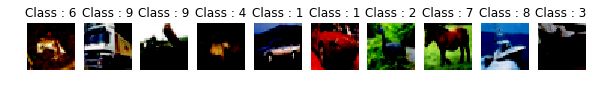

In [7]:
# 데이터 시각화
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class : ' + str(y_train[i].item()))

In [8]:
print('before np.transpose : ', X_train[0].size())
print('after np.transpose : ',np.transpose(X_train[i],(1,2,0)).size())

before np.transpose :  torch.Size([3, 32, 32])
after np.transpose :  torch.Size([32, 32, 3])


## 5. ResNet34 모델 불러오기

- **pretrained = False로 설정**하여 모델의 구조만 불러오고 **모델 구조 내에 존재하는 파라미터는 랜덤으로 샘플링한 값을 이용**한다.
- 불러온 resnet34 모델의 **Fully Connected Layer의 Input에 해당하는 노드 수**를 **num_ftrs**로 지정한다.

In [9]:
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda() # model.to(DEVICE)

## 6. Optimizer, Objective Function 설정

- ResNet 모델을 DEVICE에 할당
- 최적화 방식은 Adam
- 최적화에 사용될 손실함수는 CrossEntropyLoss

In [10]:
# model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
# print(model)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## 7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의

1. CNN 모델을 학습 상태로 지정
2. Mini-batch 단위로 저장된 데이터를 순서대로 이용하여 모델 학습
3. 이미지 데이터와 레이블 데이터를 기존에 정의한 장비에 할당
4. Optimizer 초기화
5. output 계산 
6. CrossEntropy를 통해 Loss 계산
7. Backpropagation을 통한 파라미터 업데이트

In [12]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    print("-------------------- Training..... --------------------\n")
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch: {} [{}/{}]\tTrain Loss: {:.6f}".format(Epoch,
                                                                       len(image) * batch_idx,
                                                                       len(train_loader.dataset),
                                                                       loss.item()))
    print("--------------------------------------------------------\n")   

## 8. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

1. 모델을 평가 상태로 지정
2. Gradient의 흐름을 억제하여 파라미터 값이 업데이트되는 현상 방지
3. 이후 과정은 *7. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의* 와 동일

In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label)
            prediction = output.max(1, keepdim = True)[1] # 가장 큰 확률 값을 지니는 클래스의 인덱스만 추출
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

## 9. 모델 학습 및 성능 확인

In [14]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}] Test Loss: {:.4f} \tTest Accracy: {:.2f}%\n".format(Epoch,
                                                                            test_loss,
                                                                            test_accuracy))

-------------------- Training..... --------------------

Train Epoch: 1 [0/50000]	Train Loss: 2.428457
Train Epoch: 1 [6400/50000]	Train Loss: 1.391500
Train Epoch: 1 [12800/50000]	Train Loss: 1.438986
Train Epoch: 1 [19200/50000]	Train Loss: 1.948861
Train Epoch: 1 [25600/50000]	Train Loss: 1.721593
Train Epoch: 1 [32000/50000]	Train Loss: 1.351236
Train Epoch: 1 [38400/50000]	Train Loss: 1.122242
Train Epoch: 1 [44800/50000]	Train Loss: 1.038510
--------------------------------------------------------

[EPOCH: 1] Test Loss: 0.0384 	Test Accracy: 57.23%

-------------------- Training..... --------------------

Train Epoch: 2 [0/50000]	Train Loss: 1.214507
Train Epoch: 2 [6400/50000]	Train Loss: 1.061634
Train Epoch: 2 [12800/50000]	Train Loss: 0.930815
Train Epoch: 2 [19200/50000]	Train Loss: 1.459097
Train Epoch: 2 [25600/50000]	Train Loss: 1.293411
Train Epoch: 2 [32000/50000]	Train Loss: 1.369463
Train Epoch: 2 [38400/50000]	Train Loss: 0.931824
Train Epoch: 2 [44800/50000]	Train L

## ➕ ImageNet 데이터로 학습된 ResNet34 모델을 불러온 후 Fine-tuning 해보기

In [15]:
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}] Test Loss: {:.4f} \tTest Accracy: {:.2f}%\n".format(Epoch,
                                                                            test_loss,
                                                                            test_accuracy))    

-------------------- Training..... --------------------

Train Epoch: 1 [0/50000]	Train Loss: 2.635197
Train Epoch: 1 [6400/50000]	Train Loss: 1.143671
Train Epoch: 1 [12800/50000]	Train Loss: 1.392290
Train Epoch: 1 [19200/50000]	Train Loss: 1.272022
Train Epoch: 1 [25600/50000]	Train Loss: 0.897255
Train Epoch: 1 [32000/50000]	Train Loss: 0.925618
Train Epoch: 1 [38400/50000]	Train Loss: 1.009339
Train Epoch: 1 [44800/50000]	Train Loss: 1.001643
--------------------------------------------------------

[EPOCH: 1] Test Loss: 0.0299 	Test Accracy: 68.79%

-------------------- Training..... --------------------

Train Epoch: 2 [0/50000]	Train Loss: 0.911223
Train Epoch: 2 [6400/50000]	Train Loss: 0.833055
Train Epoch: 2 [12800/50000]	Train Loss: 0.964783
Train Epoch: 2 [19200/50000]	Train Loss: 1.147692
Train Epoch: 2 [25600/50000]	Train Loss: 0.772254
Train Epoch: 2 [32000/50000]	Train Loss: 0.814888
Train Epoch: 2 [38400/50000]	Train Loss: 0.677064
Train Epoch: 2 [44800/50000]	Train L